In [ ]:
!git clone https://github.com/tensorflow/examples.git

Cloning into 'examples'...
remote: Enumerating objects: 23129, done.
remote: Counting objects: 100% (91/91), done.
remote: Compressing objects: 100% (69/69), done.
remote: Total 23129 (delta 29), reused 68 (delta 20), pack-reused 23038
Receiving objects: 100% (23129/23129), 42.20 MiB | 27.98 MiB/s, done.
Resolving deltas: 100% (12682/12682), done.


In [ ]:
!pip install Keras-Preprocessing

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 3.3 MB/s eta 0:00:00


In [ ]:
!pip install -U tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 13.5 MB/s eta 0:00:00


In [ ]:
from os import listdir
from numpy import asarray
from numpy import vstack
from keras_preprocessing.image.utils import img_to_array
from keras.utils import load_img
from keras.preprocessing import image
from numpy import savez_compressed

In [ ]:
import tensorflow as tf

from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt

In [ ]:
import keras

In [ ]:
from tensorflow_addons.layers import InstanceNormalization

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [ ]:
from matplotlib import pyplot

In [ ]:
def define_discriminator(image_shape):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# source image input
	in_image = Input(shape=image_shape)
	# C64: 4x4 kernel Stride 2x2
	d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(in_image)
	d = LeakyReLU(alpha=0.2)(d)
	# C128: 4x4 kernel Stride 2x2
	d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = InstanceNormalization(axis=-1)(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C256: 4x4 kernel Stride 2x2
	d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = InstanceNormalization(axis=-1)(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C512: 4x4 kernel Stride 2x2 
    # Not in the original paper. Comment this block if you want.
	d = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = InstanceNormalization(axis=-1)(d)
	d = LeakyReLU(alpha=0.2)(d)
	# second last output layer : 4x4 kernel but Stride 1x1
	d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
	d = InstanceNormalization(axis=-1)(d)
	d = LeakyReLU(alpha=0.2)(d)
	# patch output
	patch_out = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
	# define model
	model = Model(in_image, patch_out)
	# compile model
    #The model is trained with a batch size of one image and Adam opt. 
    #with a small learning rate and 0.5 beta. 
    #The loss for the discriminator is weighted by 50% for each model update.
    #This slows down changes to the discriminator relative to the generator model during training.
	model.compile(loss='mse', optimizer=Adam(lr=0.0002, beta_1=0.5), loss_weights=[0.5])
	return model



In [ ]:
# generator a resnet block to be used in the generator
# residual block that contains two 3 × 3 convolutional layers with the same number of filters on both layers.
def resnet_block(n_filters, input_layer):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# first convolutional layer
	g = Conv2D(n_filters, (3,3), padding='same', kernel_initializer=init)(input_layer)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# second convolutional layer
	g = Conv2D(n_filters, (3,3), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	# concatenate merge channel-wise with input layer
	g = Concatenate()([g, input_layer])
	return g

In [ ]:
def define_generator(image_shape, n_resnet=9):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# image input
	in_image = Input(shape=image_shape)
	# c7s1-64
	g = Conv2D(64, (7,7), padding='same', kernel_initializer=init)(in_image)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# d128
	g = Conv2D(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# d256
	g = Conv2D(256, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# R256
	for _ in range(n_resnet):
		g = resnet_block(256, g)
	# u128
	g = Conv2DTranspose(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# u64
	g = Conv2DTranspose(64, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# c7s1-3
	g = Conv2D(3, (7,7), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	out_image = Activation('tanh')(g)
	# define model
	model = Model(in_image, out_image)
	return model

# define a composite model for updating generators by adversarial and cycle loss
#We define a composite model that will be used to train each generator separately. 
def define_composite_model(g_model_1, d_model, g_model_2, image_shape):
	# Make the generator of interest trainable as we will be updating these weights.
    #by keeping other models constant.
    #Remember that we use this same function to train both generators,
    #one generator at a time. 
	g_model_1.trainable = True
	# mark discriminator and second generator as non-trainable
	d_model.trainable = False
	g_model_2.trainable = False
    
	# adversarial loss
	input_gen = Input(shape=image_shape)
	gen1_out = g_model_1(input_gen)
	output_d = d_model(gen1_out)
	# identity loss
	input_id = Input(shape=image_shape)
	output_id = g_model_1(input_id)
	# cycle loss - forward
	output_f = g_model_2(gen1_out)
	# cycle loss - backward
	gen2_out = g_model_2(input_id)
	output_b = g_model_1(gen2_out)
    
	# define model graph
	model = Model([input_gen, input_id], [output_d, output_id, output_f, output_b])
	
    # define the optimizer
	opt = Adam(lr=0.0002, beta_1=0.5)
	# compile model with weighting of least squares loss and L1 loss
	model.compile(loss=['mse', 'mae', 'mae', 'mae'], 
               loss_weights=[1, 5, 10, 10], optimizer=opt)
	return model

# load and prepare training images
def load_real_samples(filename):
	# load the dataset
	data = load(filename)
	# unpack arrays
	X1, X2 = data['arr_0'], data['arr_1']
	# scale from [0,255] to [-1,1]
	X1 = (X1 - 127.5) / 127.5
	X2 = (X2 - 127.5) / 127.5
	return [X1, X2]

# select a batch of random samples, returns images and target
#Remember that for real images the label (y) is 1. 
def generate_real_samples(dataset, n_samples, patch_shape):
	# choose random instances
	ix = randint(0, dataset.shape[0], n_samples)
	# retrieve selected images
	X = dataset[ix]
	# generate 'real' class labels (1)
	y = ones((n_samples, patch_shape, patch_shape, 1))
	return X, y

# generate a batch of images, returns images and targets
#Remember that for fake images the label (y) is 0. 
def generate_fake_samples(g_model, dataset, patch_shape):
	# generate fake images
	X = g_model.predict(dataset)
	# create 'fake' class labels (0)
	y = zeros((len(X), patch_shape, patch_shape, 1))
	return X, y

# periodically save the generator models to file
def save_models(step, g_model_AtoB, g_model_BtoA):
	# save the first generator model
	filename1 = 'g_model_AtoB_%06d.h5' % (step+1)
	g_model_AtoB.save(filename1)
	# save the second generator model
	filename2 = 'g_model_BtoA_%06d.h5' % (step+1)
	g_model_BtoA.save(filename2)
	print('>Saved: %s and %s' % (filename1, filename2))

# periodically generate images using the save model and plot input and output images
def summarize_performance(step, g_model, trainX, name, n_samples=5):
	# select a sample of input images
	X_in, _ = generate_real_samples(trainX, n_samples, 0)
	# generate translated images
	X_out, _ = generate_fake_samples(g_model, X_in, 0)
	# scale all pixels from [-1,1] to [0,1]
	X_in = (X_in + 1) / 2.0
	X_out = (X_out + 1) / 2.0
	# plot real images
	for i in range(n_samples):
		pyplot.subplot(2, n_samples, 1 + i)
		pyplot.axis('off')
		pyplot.imshow(X_in[i])
	# plot translated image
	for i in range(n_samples):
		pyplot.subplot(2, n_samples, 1 + n_samples + i)
		pyplot.axis('off')
		pyplot.imshow(X_out[i])
	# save plot to file
	filename1 = '%s_generated_plot_%06d.png' % (name, (step+1))
	pyplot.savefig(filename1)
	pyplot.close()

# update image pool for fake images to reduce model oscillation
# update discriminators using a history of generated images 
#rather than the ones produced by the latest generators.
#Original paper recommended keeping an image buffer that stores 
#the 50 previously created images.

def update_image_pool(pool, images, max_size=50):
	selected = list()
	for image in images:
		if len(pool) < max_size:
			# stock the pool
			pool.append(image)
			selected.append(image)
		elif random() < 0.5:
			# use image, but don't add it to the pool
			selected.append(image)
		else:
			# replace an existing image and use replaced image
			ix = randint(0, len(pool))
			selected.append(pool[ix])
			pool[ix] = image
	return asarray(selected)

# train cyclegan models
def train(d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA, dataset, epochs=1):
	# define properties of the training run
	n_epochs, n_batch, = epochs, 1  #batch size fixed to 1 as suggested in the paper
	# determine the output square shape of the discriminator
	n_patch = d_model_A.output_shape[1]
	# unpack dataset
	trainA, trainB = dataset
	# prepare image pool for fake images
	poolA, poolB = list(), list()
	# calculate the number of batches per training epoch
	bat_per_epo = int(len(trainA) / n_batch)
	# calculate the number of training iterations
	n_steps = bat_per_epo * n_epochs
    
	# manually enumerate epochs
	for i in range(n_steps):
		# select a batch of real samples from each domain (A and B)
		X_realA, y_realA = generate_real_samples(trainA, n_batch, n_patch)
		X_realB, y_realB = generate_real_samples(trainB, n_batch, n_patch)
		# generate a batch of fake samples using both B to A and A to B generators.
		X_fakeA, y_fakeA = generate_fake_samples(g_model_BtoA, X_realB, n_patch)
		X_fakeB, y_fakeB = generate_fake_samples(g_model_AtoB, X_realA, n_patch)
		# update fake images in the pool. Remember that the paper suggstes a buffer of 50 images
		X_fakeA = update_image_pool(poolA, X_fakeA)
		X_fakeB = update_image_pool(poolB, X_fakeB)
        
		# update generator B->A via the composite model
		g_loss2, _, _, _, _  = c_model_BtoA.train_on_batch([X_realB, X_realA], [y_realA, X_realA, X_realB, X_realA])
		# update discriminator for A -> [real/fake]
		dA_loss1 = d_model_A.train_on_batch(X_realA, y_realA)
		dA_loss2 = d_model_A.train_on_batch(X_fakeA, y_fakeA)
		
        # update generator A->B via the composite model
		g_loss1, _, _, _, _ = c_model_AtoB.train_on_batch([X_realA, X_realB], [y_realB, X_realB, X_realA, X_realB])
		# update discriminator for B -> [real/fake]
		dB_loss1 = d_model_B.train_on_batch(X_realB, y_realB)
		dB_loss2 = d_model_B.train_on_batch(X_fakeB, y_fakeB)
		
        # summarize performance
        #Since our batch size =1, the number of iterations would be same as the size of our dataset.
        #In one epoch you'd have iterations equal to the number of images.
        #If you have 100 images then 1 epoch would be 100 iterations
		print('Iteration>%d, dA[%.3f,%.3f] dB[%.3f,%.3f] g[%.3f,%.3f]' % (i+1, dA_loss1,dA_loss2, dB_loss1,dB_loss2, g_loss1,g_loss2))
		# evaluate the model performance periodically
        #If batch size (total images)=100, performance will be summarized after every 75th iteration.
		if (i+1) % (bat_per_epo * 1) == 0:
			# plot A->B translation
			summarize_performance(i, g_model_AtoB, trainA, 'AtoB')
			# plot B->A translation
			summarize_performance(i, g_model_BtoA, trainB, 'BtoA')
		if (i+1) % (bat_per_epo * 5) == 0:
			# save the models
            # #If batch size (total images)=100, model will be saved after 
            #every 75th iteration x 5 = 375 iterations.
			save_models(i, g_model_AtoB, g_model_BtoA)

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
from random import random
from numpy import load
from numpy import zeros
from numpy import ones
from numpy import asarray
from numpy.random import randint
from keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.models import Model
from tensorflow.keras import Input
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Concatenate

In [ ]:

from os import listdir
from numpy import asarray
from numpy import vstack
from keras_preprocessing.image.utils import img_to_array
from keras.utils import load_img
from matplotlib import pyplot as plt
import numpy as np

Loaded dataA:  (115, 256, 256, 3)
Loaded dataB:  (115, 256, 256, 3)


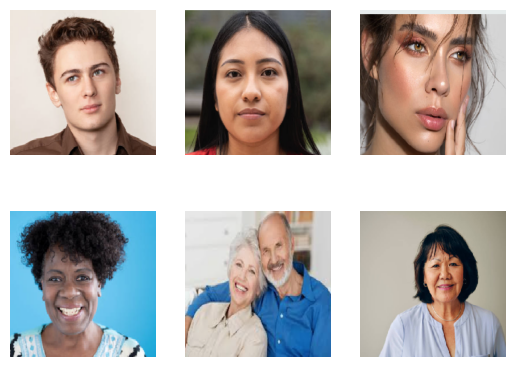

Loaded (50, 256, 256, 3) (50, 256, 256, 3)
1/1 [==============================] - 1s 976ms/step


Iteration>1, dA[0.943,1.330] dB[1.432,1.216] g[20.547,19.180]
1/1 [==============================] - 0s 23ms/step
Iteration>2, dA[4.127,1.447] dB[6.979,2.834] g[17.251,20.141]
1/1 [==============================] - 0s 23ms/step
Iteration>3, dA[13.160,2.458] dB[3.573,2.112] g[17.985,18.432]
1/1 [==============================] - 0s 42ms/step
Iteration>4, dA[3.682,3.952] dB[8.662,2.952] g[20.861,21.874]
1/1 [==============================] - 0s 39ms/step
Iteration>5, dA[1.556,3.588] dB[3.639,2.648] g[15.750,17.303]
1/1 [==============================] - 0s 26ms/step
Iteration>6, dA[1.406,2.696] dB[3.852,2.175] g[13.761,17.680]
1/1 [==============================] - 0s 23ms/step
Iteration>7, dA[1.520,1.172] dB[1.329,1.268] g[12.373,14.515]
1/1 [==============================] - 0s 25ms/step
Iteration>8, dA[1.526,0.889] dB[1.063,0.892] g[11.477,13.209]
1/1 [==============================] - 0s 25ms/step
Iteration>9, dA[0.936,0.782] dB[0.753,1.202] g[12.812,12.590]
1/1 [====================

>Saved: g_model_AtoB_000250.h5 and g_model_BtoA_000250.h5
1/1 [==============================] - 0s 27ms/step
Iteration>251, dA[0.119,0.257] dB[0.234,0.162] g[7.399,9.541]
1/1 [==============================] - 0s 34ms/step
Iteration>252, dA[0.175,0.129] dB[0.098,0.089] g[5.473,5.432]
1/1 [==============================] - 0s 29ms/step
Iteration>253, dA[0.250,0.160] dB[0.181,0.225] g[5.879,6.443]
1/1 [==============================] - 0s 38ms/step
Iteration>254, dA[0.131,0.171] dB[0.184,0.062] g[4.927,5.165]
1/1 [==============================] - 0s 40ms/step
Iteration>255, dA[0.116,0.185] dB[0.105,0.164] g[5.855,5.270]
1/1 [==============================] - 0s 25ms/step
Iteration>256, dA[0.103,0.063] dB[0.131,0.084] g[5.085,5.393]
1/1 [==============================] - 0s 23ms/step
Iteration>257, dA[0.188,0.140] dB[0.063,0.130] g[4.305,4.705]
1/1 [==============================] - 0s 28ms/step
Iteration>258, dA[0.109,0.108] dB[0.148,0.064] g[5.821,6.667]
1/1 [=========================

>Saved: g_model_AtoB_000500.h5 and g_model_BtoA_000500.h5
1/1 [==============================] - 0s 27ms/step
Iteration>501, dA[0.128,0.087] dB[0.037,0.042] g[4.358,4.705]
1/1 [==============================] - 0s 23ms/step
Iteration>502, dA[0.162,0.090] dB[0.083,0.137] g[4.937,4.700]
1/1 [==============================] - 0s 24ms/step
Iteration>503, dA[0.052,0.094] dB[0.039,0.045] g[7.339,6.362]
1/1 [==============================] - 0s 33ms/step
Iteration>504, dA[0.068,0.077] dB[0.084,0.039] g[6.704,6.348]
1/1 [==============================] - 0s 27ms/step
Iteration>505, dA[0.175,0.087] dB[0.198,0.135] g[4.661,4.551]
1/1 [==============================] - 0s 22ms/step
Iteration>506, dA[0.143,0.194] dB[0.091,0.138] g[3.237,3.308]
1/1 [==============================] - 0s 23ms/step
Iteration>507, dA[0.249,0.143] dB[0.084,0.128] g[6.281,5.501]
1/1 [==============================] - 0s 21ms/step
Iteration>508, dA[0.104,0.038] dB[0.027,0.049] g[10.324,8.842]
1/1 [========================

>Saved: g_model_AtoB_000750.h5 and g_model_BtoA_000750.h5
1/1 [==============================] - 0s 26ms/step
Iteration>751, dA[0.102,0.225] dB[0.046,0.061] g[3.733,3.675]
1/1 [==============================] - 0s 38ms/step
Iteration>752, dA[0.154,0.071] dB[0.071,0.062] g[4.302,5.647]
1/1 [==============================] - 0s 29ms/step
Iteration>753, dA[0.037,0.218] dB[0.239,0.081] g[5.388,5.781]
1/1 [==============================] - 0s 29ms/step
Iteration>754, dA[0.125,0.070] dB[0.071,0.163] g[5.810,6.173]
1/1 [==============================] - 0s 24ms/step
Iteration>755, dA[0.082,0.127] dB[0.027,0.137] g[5.194,5.301]
1/1 [==============================] - 0s 25ms/step
Iteration>756, dA[0.072,0.073] dB[0.284,0.056] g[6.458,5.701]
1/1 [==============================] - 0s 22ms/step
Iteration>757, dA[0.074,0.038] dB[0.025,0.136] g[4.834,5.259]
1/1 [==============================] - 0s 42ms/step
Iteration>758, dA[0.072,0.080] dB[0.104,0.048] g[6.021,6.084]
1/1 [=========================

>Saved: g_model_AtoB_001000.h5 and g_model_BtoA_001000.h5
1/1 [==============================] - 0s 24ms/step
Iteration>1001, dA[0.221,0.035] dB[0.061,0.095] g[3.744,4.466]
1/1 [==============================] - 0s 23ms/step
Iteration>1002, dA[0.044,0.096] dB[0.287,0.124] g[4.832,4.484]
1/1 [==============================] - 0s 39ms/step
Iteration>1003, dA[0.021,0.065] dB[0.071,0.250] g[4.127,5.218]
1/1 [==============================] - 0s 26ms/step
Iteration>1004, dA[0.260,0.175] dB[0.023,0.017] g[9.294,9.545]
1/1 [==============================] - 0s 26ms/step
Iteration>1005, dA[0.091,0.338] dB[0.329,0.113] g[6.043,5.744]
1/1 [==============================] - 0s 25ms/step
Iteration>1006, dA[0.169,0.066] dB[0.069,0.156] g[5.773,6.169]
1/1 [==============================] - 0s 22ms/step
Iteration>1007, dA[0.252,0.078] dB[0.029,0.113] g[4.111,4.596]
1/1 [==============================] - 0s 23ms/step
Iteration>1008, dA[0.060,0.060] dB[0.059,0.033] g[6.967,6.350]
1/1 [=================

>Saved: g_model_AtoB_001250.h5 and g_model_BtoA_001250.h5
1/1 [==============================] - 0s 32ms/step
Iteration>1251, dA[0.327,0.111] dB[0.042,0.347] g[5.583,6.514]
1/1 [==============================] - 0s 25ms/step
Iteration>1252, dA[0.075,0.140] dB[0.153,0.064] g[3.618,3.414]
1/1 [==============================] - 0s 23ms/step
Iteration>1253, dA[0.042,0.103] dB[0.191,0.208] g[4.140,3.772]
1/1 [==============================] - 0s 23ms/step
Iteration>1254, dA[0.072,0.036] dB[0.033,0.038] g[6.223,7.453]
1/1 [==============================] - 0s 26ms/step
Iteration>1255, dA[0.147,0.127] dB[0.186,0.095] g[3.579,3.773]
1/1 [==============================] - 0s 29ms/step
Iteration>1256, dA[0.156,0.180] dB[0.013,0.200] g[4.173,4.201]
1/1 [==============================] - 0s 32ms/step
Iteration>1257, dA[0.049,0.130] dB[0.574,0.020] g[5.948,5.040]
1/1 [==============================] - 0s 34ms/step
Iteration>1258, dA[0.202,0.089] dB[0.025,0.096] g[3.814,4.491]
1/1 [=================

>Saved: g_model_AtoB_001500.h5 and g_model_BtoA_001500.h5
1/1 [==============================] - 0s 22ms/step
Iteration>1501, dA[0.044,0.102] dB[0.344,0.081] g[4.897,3.985]
1/1 [==============================] - 0s 25ms/step
Iteration>1502, dA[0.118,0.027] dB[0.053,0.162] g[5.205,5.842]
1/1 [==============================] - 0s 28ms/step
Iteration>1503, dA[0.053,0.187] dB[0.105,0.038] g[4.314,4.272]
1/1 [==============================] - 0s 23ms/step
Iteration>1504, dA[0.028,0.027] dB[0.137,0.080] g[4.805,4.499]
1/1 [==============================] - 0s 39ms/step
Iteration>1505, dA[0.034,0.057] dB[0.044,0.253] g[3.792,5.639]
1/1 [==============================] - 0s 46ms/step
Iteration>1506, dA[0.118,0.074] dB[0.042,0.046] g[8.378,6.894]
1/1 [==============================] - 0s 22ms/step
Iteration>1507, dA[0.048,0.085] dB[0.097,0.031] g[4.967,4.793]
1/1 [==============================] - 0s 22ms/step
Iteration>1508, dA[0.064,0.066] dB[0.029,0.119] g[6.296,6.829]
1/1 [=================

>Saved: g_model_AtoB_001750.h5 and g_model_BtoA_001750.h5
1/1 [==============================] - 0s 47ms/step
Iteration>1751, dA[0.085,0.059] dB[0.285,0.076] g[4.910,5.716]
1/1 [==============================] - 0s 46ms/step
Iteration>1752, dA[0.049,0.052] dB[0.078,0.068] g[5.187,6.041]
1/1 [==============================] - 0s 28ms/step
Iteration>1753, dA[0.072,0.056] dB[0.096,0.013] g[5.096,5.471]
1/1 [==============================] - 0s 39ms/step
Iteration>1754, dA[0.119,0.077] dB[0.015,0.035] g[4.779,5.407]
1/1 [==============================] - 0s 30ms/step
Iteration>1755, dA[0.153,0.059] dB[0.023,0.051] g[5.735,6.045]
1/1 [==============================] - 0s 31ms/step
Iteration>1756, dA[0.024,0.061] dB[0.348,0.252] g[4.413,4.634]
1/1 [==============================] - 0s 43ms/step
Iteration>1757, dA[0.045,0.089] dB[0.078,0.215] g[3.412,3.841]
1/1 [==============================] - 0s 57ms/step
Iteration>1758, dA[0.040,0.052] dB[0.023,0.050] g[3.670,3.938]
1/1 [=================

>Saved: g_model_AtoB_002000.h5 and g_model_BtoA_002000.h5
1/1 [==============================] - 0s 46ms/step
Iteration>2001, dA[0.076,0.086] dB[0.204,0.151] g[4.378,4.532]
1/1 [==============================] - 0s 28ms/step
Iteration>2002, dA[0.372,0.173] dB[0.032,0.057] g[4.612,5.709]
1/1 [==============================] - 0s 31ms/step
Iteration>2003, dA[0.065,0.134] dB[0.062,0.046] g[3.954,5.122]
1/1 [==============================] - 0s 31ms/step
Iteration>2004, dA[0.031,0.035] dB[0.057,0.052] g[8.252,8.551]
1/1 [==============================] - 0s 27ms/step
Iteration>2005, dA[0.260,0.145] dB[0.228,0.041] g[3.118,3.604]
1/1 [==============================] - 0s 40ms/step
Iteration>2006, dA[0.047,0.140] dB[0.033,0.208] g[5.210,4.906]
1/1 [==============================] - 0s 44ms/step
Iteration>2007, dA[0.061,0.037] dB[0.153,0.011] g[4.812,5.267]
1/1 [==============================] - 0s 26ms/step
Iteration>2008, dA[0.090,0.038] dB[0.026,0.019] g[6.070,5.949]
1/1 [=================

>Saved: g_model_AtoB_002250.h5 and g_model_BtoA_002250.h5
1/1 [==============================] - 0s 24ms/step
Iteration>2251, dA[0.032,0.053] dB[0.166,0.041] g[4.041,4.251]
1/1 [==============================] - 0s 39ms/step
Iteration>2252, dA[0.090,0.051] dB[0.029,0.062] g[3.684,3.892]
1/1 [==============================] - 0s 33ms/step
Iteration>2253, dA[0.048,0.091] dB[0.060,0.041] g[6.542,5.903]
1/1 [==============================] - 0s 25ms/step
Iteration>2254, dA[0.046,0.129] dB[0.087,0.090] g[3.325,3.162]
1/1 [==============================] - 0s 22ms/step
Iteration>2255, dA[0.048,0.073] dB[0.172,0.134] g[3.759,4.039]
1/1 [==============================] - 0s 29ms/step
Iteration>2256, dA[0.059,0.021] dB[0.017,0.059] g[5.768,5.540]
1/1 [==============================] - 0s 25ms/step
Iteration>2257, dA[0.085,0.048] dB[0.115,0.050] g[4.828,5.737]
1/1 [==============================] - 0s 23ms/step
Iteration>2258, dA[0.058,0.217] dB[0.024,0.065] g[4.739,4.285]
1/1 [=================

>Saved: g_model_AtoB_002500.h5 and g_model_BtoA_002500.h5
1/1 [==============================] - 0s 31ms/step
Iteration>2501, dA[0.058,0.160] dB[0.192,0.026] g[4.158,3.510]
1/1 [==============================] - 0s 31ms/step
Iteration>2502, dA[0.091,0.052] dB[0.180,0.381] g[3.783,3.732]
1/1 [==============================] - 0s 26ms/step
Iteration>2503, dA[0.060,0.032] dB[0.076,0.127] g[4.938,4.607]
1/1 [==============================] - 0s 40ms/step
Iteration>2504, dA[0.117,0.055] dB[0.061,0.030] g[6.561,5.880]
1/1 [==============================] - 0s 35ms/step
Iteration>2505, dA[0.168,0.061] dB[0.131,0.048] g[5.046,5.388]
1/1 [==============================] - 0s 29ms/step
Iteration>2506, dA[0.067,0.069] dB[0.036,0.032] g[6.459,6.465]
1/1 [==============================] - 0s 22ms/step
Iteration>2507, dA[0.161,0.181] dB[0.115,0.022] g[3.781,3.506]
1/1 [==============================] - 0s 31ms/step
Iteration>2508, dA[0.072,0.094] dB[0.077,0.105] g[4.095,4.596]
1/1 [=================

>Saved: g_model_AtoB_002750.h5 and g_model_BtoA_002750.h5
1/1 [==============================] - 0s 24ms/step
Iteration>2751, dA[0.046,0.088] dB[0.306,0.067] g[3.511,3.887]
1/1 [==============================] - 0s 22ms/step
Iteration>2752, dA[0.014,0.030] dB[0.109,0.134] g[5.032,6.984]
1/1 [==============================] - 0s 27ms/step
Iteration>2753, dA[0.115,0.089] dB[0.057,0.080] g[7.605,6.708]
1/1 [==============================] - 0s 27ms/step
Iteration>2754, dA[0.092,0.026] dB[0.273,0.171] g[3.505,3.582]
1/1 [==============================] - 0s 23ms/step
Iteration>2755, dA[0.021,0.063] dB[0.047,0.083] g[4.397,5.065]
1/1 [==============================] - 0s 32ms/step
Iteration>2756, dA[0.053,0.045] dB[0.091,0.082] g[3.019,3.973]
1/1 [==============================] - 0s 25ms/step
Iteration>2757, dA[0.199,0.102] dB[0.031,0.032] g[3.805,4.256]
1/1 [==============================] - 0s 26ms/step
Iteration>2758, dA[0.029,0.055] dB[0.014,0.022] g[6.607,6.201]
1/1 [=================

>Saved: g_model_AtoB_003000.h5 and g_model_BtoA_003000.h5
1/1 [==============================] - 0s 38ms/step
Iteration>3001, dA[0.153,0.101] dB[0.028,0.053] g[4.224,5.476]
1/1 [==============================] - 0s 39ms/step
Iteration>3002, dA[0.106,0.054] dB[0.333,0.191] g[3.934,4.536]
1/1 [==============================] - 0s 23ms/step
Iteration>3003, dA[0.025,0.032] dB[0.039,0.060] g[3.511,3.735]
1/1 [==============================] - 0s 22ms/step
Iteration>3004, dA[0.073,0.066] dB[0.303,0.052] g[5.040,6.550]
1/1 [==============================] - 0s 22ms/step
Iteration>3005, dA[0.014,0.027] dB[0.047,0.287] g[5.494,7.079]
1/1 [==============================] - 0s 24ms/step
Iteration>3006, dA[0.136,0.106] dB[0.222,0.191] g[3.696,4.158]
1/1 [==============================] - 0s 27ms/step
Iteration>3007, dA[0.119,0.160] dB[0.089,0.092] g[5.637,5.076]
1/1 [==============================] - 0s 50ms/step
Iteration>3008, dA[0.041,0.043] dB[0.492,0.130] g[5.539,6.286]
1/1 [=================

>Saved: g_model_AtoB_003250.h5 and g_model_BtoA_003250.h5
1/1 [==============================] - 0s 24ms/step
Iteration>3251, dA[0.059,0.200] dB[0.098,0.028] g[3.735,3.965]
1/1 [==============================] - 0s 26ms/step
Iteration>3252, dA[0.031,0.036] dB[0.031,0.076] g[4.322,4.400]
1/1 [==============================] - 0s 27ms/step
Iteration>3253, dA[0.028,0.102] dB[0.084,0.019] g[4.716,4.927]
1/1 [==============================] - 0s 37ms/step
Iteration>3254, dA[0.015,0.149] dB[0.074,0.057] g[5.328,5.183]
1/1 [==============================] - 0s 47ms/step
Iteration>3255, dA[0.191,0.033] dB[0.033,0.064] g[5.020,6.858]
1/1 [==============================] - 0s 30ms/step
Iteration>3256, dA[0.007,0.122] dB[0.019,0.055] g[3.282,3.815]
1/1 [==============================] - 0s 25ms/step
Iteration>3257, dA[0.064,0.011] dB[0.040,0.020] g[4.200,4.671]
1/1 [==============================] - 0s 27ms/step
Iteration>3258, dA[0.121,0.261] dB[0.059,0.185] g[2.448,2.836]
1/1 [=================

>Saved: g_model_AtoB_003500.h5 and g_model_BtoA_003500.h5
1/1 [==============================] - 0s 25ms/step
Iteration>3501, dA[0.033,0.042] dB[0.175,0.220] g[4.195,4.734]
1/1 [==============================] - 0s 21ms/step
Iteration>3502, dA[0.029,0.037] dB[0.086,0.034] g[5.576,5.249]
1/1 [==============================] - 0s 23ms/step
Iteration>3503, dA[0.028,0.108] dB[0.057,0.027] g[7.095,5.827]
1/1 [==============================] - 0s 34ms/step
Iteration>3504, dA[0.039,0.026] dB[0.069,0.081] g[6.466,6.922]
1/1 [==============================] - 0s 40ms/step
Iteration>3505, dA[0.060,0.077] dB[0.091,0.054] g[4.177,4.119]
1/1 [==============================] - 0s 22ms/step
Iteration>3506, dA[0.050,0.043] dB[0.052,0.089] g[6.001,6.756]
1/1 [==============================] - 0s 25ms/step
Iteration>3507, dA[0.027,0.044] dB[0.050,0.175] g[3.945,4.911]
1/1 [==============================] - 0s 27ms/step
Iteration>3508, dA[0.082,0.041] dB[0.104,0.054] g[4.691,4.996]
1/1 [=================

>Saved: g_model_AtoB_003750.h5 and g_model_BtoA_003750.h5
1/1 [==============================] - 0s 29ms/step
Iteration>3751, dA[0.041,0.016] dB[0.068,0.139] g[3.539,4.322]
1/1 [==============================] - 0s 56ms/step
Iteration>3752, dA[0.233,0.175] dB[0.200,0.361] g[3.626,4.303]
1/1 [==============================] - 0s 35ms/step
Iteration>3753, dA[0.044,0.228] dB[0.091,0.027] g[3.487,3.308]
1/1 [==============================] - 0s 22ms/step
Iteration>3754, dA[0.059,0.010] dB[0.092,0.043] g[4.309,5.174]
1/1 [==============================] - 0s 22ms/step
Iteration>3755, dA[0.027,0.019] dB[0.012,0.111] g[6.189,7.253]
1/1 [==============================] - 0s 28ms/step
Iteration>3756, dA[0.017,0.048] dB[0.106,0.034] g[4.507,6.247]
1/1 [==============================] - 0s 25ms/step
Iteration>3757, dA[0.026,0.046] dB[0.193,0.381] g[2.992,3.296]
1/1 [==============================] - 0s 24ms/step
Iteration>3758, dA[0.044,0.052] dB[0.045,0.057] g[4.385,4.518]
1/1 [=================

>Saved: g_model_AtoB_004000.h5 and g_model_BtoA_004000.h5
1/1 [==============================] - 0s 26ms/step
Iteration>4001, dA[0.039,0.043] dB[0.072,0.062] g[5.201,5.043]
1/1 [==============================] - 0s 42ms/step
Iteration>4002, dA[0.011,0.024] dB[0.037,0.094] g[3.313,4.097]
1/1 [==============================] - 0s 38ms/step
Iteration>4003, dA[0.125,0.023] dB[0.016,0.040] g[5.061,5.925]
1/1 [==============================] - 0s 23ms/step
Iteration>4004, dA[0.098,0.029] dB[0.034,0.031] g[7.861,6.554]
1/1 [==============================] - 0s 26ms/step
Iteration>4005, dA[0.059,0.030] dB[0.065,0.026] g[5.132,4.661]
1/1 [==============================] - 0s 22ms/step
Iteration>4006, dA[0.039,0.146] dB[0.049,0.034] g[6.740,5.677]
1/1 [==============================] - 0s 25ms/step
Iteration>4007, dA[0.031,0.029] dB[0.059,0.024] g[3.493,3.973]
1/1 [==============================] - 0s 21ms/step
Iteration>4008, dA[0.052,0.022] dB[0.104,0.125] g[4.434,4.553]
1/1 [=================

>Saved: g_model_AtoB_004250.h5 and g_model_BtoA_004250.h5
1/1 [==============================] - 0s 23ms/step
Iteration>4251, dA[0.031,0.025] dB[0.077,0.207] g[3.524,4.253]
1/1 [==============================] - 0s 37ms/step
Iteration>4252, dA[0.017,0.106] dB[0.015,0.026] g[5.201,4.348]
1/1 [==============================] - 0s 35ms/step
Iteration>4253, dA[0.072,0.055] dB[0.052,0.038] g[3.534,4.737]
1/1 [==============================] - 0s 30ms/step
Iteration>4254, dA[0.036,0.082] dB[0.037,0.051] g[4.957,4.252]
1/1 [==============================] - 0s 34ms/step
Iteration>4255, dA[0.085,0.039] dB[0.047,0.022] g[2.760,3.281]
1/1 [==============================] - 0s 30ms/step
Iteration>4256, dA[0.089,0.094] dB[0.042,0.022] g[4.232,4.341]
1/1 [==============================] - 0s 28ms/step
Iteration>4257, dA[0.056,0.040] dB[0.114,0.091] g[3.610,3.354]
1/1 [==============================] - 0s 41ms/step
Iteration>4258, dA[0.247,0.025] dB[0.017,0.030] g[2.747,4.389]
1/1 [=================

>Saved: g_model_AtoB_004500.h5 and g_model_BtoA_004500.h5
1/1 [==============================] - 0s 22ms/step
Iteration>4501, dA[0.045,0.073] dB[0.035,0.096] g[4.963,4.923]
1/1 [==============================] - 0s 23ms/step
Iteration>4502, dA[0.108,0.016] dB[0.218,0.044] g[5.041,4.954]
1/1 [==============================] - 0s 23ms/step
Iteration>4503, dA[0.036,0.014] dB[0.024,0.021] g[5.268,4.695]
1/1 [==============================] - 0s 24ms/step
Iteration>4504, dA[0.043,0.045] dB[0.180,0.033] g[3.462,3.568]
1/1 [==============================] - 0s 33ms/step
Iteration>4505, dA[0.035,0.084] dB[0.020,0.038] g[2.622,3.175]
1/1 [==============================] - 0s 54ms/step
Iteration>4506, dA[0.059,0.014] dB[0.061,0.082] g[3.345,3.607]
1/1 [==============================] - 0s 22ms/step
Iteration>4507, dA[0.041,0.011] dB[0.055,0.037] g[2.931,3.708]
1/1 [==============================] - 0s 22ms/step
Iteration>4508, dA[0.020,0.103] dB[0.032,0.080] g[3.520,4.406]
1/1 [=================

OSError: ignored

In [ ]:

# load all images in a directory into memory
def load_images(path, size=(256,256)):
	data_list = list()
	# enumerate filenames in directory, assume all are images
	for filename in listdir(path):
		# load and resize the image
		pixels = load_img(path + filename, target_size=size)
		# convert to numpy array
		pixels = img_to_array(pixels)
		# store
		data_list.append(pixels)
	return asarray(data_list)


# dataset path
path = '/content/drive/MyDrive/young2old/'

# load dataset A - Monet paintings
dataA_all = load_images(path + 'trainA/')
print('Loaded dataA: ', dataA_all.shape)

from sklearn.utils import resample
#To get a subset of all images, for faster training during demonstration
dataA = resample(dataA_all, 
                 replace=False,     
                 n_samples=50,    
                 random_state=42) 

# load dataset B - Photos 
dataB_all = load_images(path + 'trainB/')
print('Loaded dataB: ', dataB_all.shape)
#Get a subset of all images, for faster training during demonstration
#We could have just read the list of files and only load a subset, better memory management. 
dataB = resample(dataB_all, 
                 replace=False,     
                 n_samples=50,    
                 random_state=42) 

# plot source images
n_samples = 3
for i in range(n_samples):
	plt.subplot(2, n_samples, 1 + i)
	plt.axis('off')
	plt.imshow(dataA[i].astype('uint8'))
# plot target image
for i in range(n_samples):
	plt.subplot(2, n_samples, 1 + n_samples + i)
	plt.axis('off')
	plt.imshow(dataB[i].astype('uint8'))
plt.show()



# load image data
data = [dataA, dataB]

print('Loaded', data[0].shape, data[1].shape)

#Preprocess data to change input range to values between -1 and 1
# This is because the generator uses tanh activation in the output layer
#And tanh ranges between -1 and 1
def preprocess_data(data):
	# load compressed arrays
	# unpack arrays
	X1, X2 = data[0], data[1]
	# scale from [0,255] to [-1,1]
	X1 = (X1 - 127.5) / 127.5
	X2 = (X2 - 127.5) / 127.5
	return [X1, X2]

dataset = preprocess_data(data)

#from cycleGAN_model import define_generator, define_discriminator, define_composite_model, train
# define input shape based on the loaded dataset
image_shape = dataset[0].shape[1:]
# generator: A -> B
g_model_AtoB = define_generator(image_shape)
# generator: B -> A
g_model_BtoA = define_generator(image_shape)
# discriminator: A -> [real/fake]
d_model_A = define_discriminator(image_shape)
# discriminator: B -> [real/fake]
d_model_B = define_discriminator(image_shape)
# composite: A -> B -> [real/fake, A]
c_model_AtoB = define_composite_model(g_model_AtoB, d_model_B, g_model_BtoA, image_shape)
# composite: B -> A -> [real/fake, B]
c_model_BtoA = define_composite_model(g_model_BtoA, d_model_A, g_model_AtoB, image_shape)

from datetime import datetime 
start1 = datetime.now() 
# train models
train(d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA, dataset, epochs=91)

stop1 = datetime.now()
#Execution time of the model 
execution_time = stop1-start1
print("Execution time is: ", execution_time)

############################################

# Use the saved cyclegan models for image translation
from tensorflow_addons.layers import InstanceNormalization 
from keras.models import load_model
from matplotlib import pyplot
from numpy.random import randint

# select a random sample of images from the dataset
def select_sample(dataset, n_samples):
	# choose random instances
	ix = randint(0, dataset.shape[0], n_samples)
	# retrieve selected images
	X = dataset[ix]
	return X

# plot the image, its translation, and the reconstruction
def show_plot(imagesX, imagesY1, imagesY2):
	images = vstack((imagesX, imagesY1, imagesY2))
	titles = ['Real', 'Generated', 'Reconstructed']
	# scale from [-1,1] to [0,1]
	images = (images + 1) / 2.0
	# plot images row by row
	for i in range(len(images)):
		# define subplot
		pyplot.subplot(1, len(images), 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(images[i])
		# title
		pyplot.title(titles[i])
	pyplot.show()

# load dataset
A_data = resample(dataA_all, 
                 replace=False,     
                 n_samples=20,    
                 random_state=42) # reproducible results

B_data = resample(dataB_all, 
                 replace=False,     
                 n_samples=20,    
                 random_state=42) # reproducible results

A_data = (A_data - 127.5) / 127.5
B_data = (B_data - 127.5) / 127.5


# load the models
cust = {'InstanceNormalization': InstanceNormalization}
model_AtoB = load_model('g_model_AtoB.h5', cust)
model_BtoA = load_model('g_model_BtoA.h5', cust)

# plot A->B->A (Monet to photo to Monet)
A_real = select_sample(A_data, 1)
B_generated  = model_AtoB.predict(A_real)
A_reconstructed = model_BtoA.predict(B_generated)
show_plot(A_real, B_generated, A_reconstructed)
# plot B->A->B (Photo to Monet to Photo)
B_real = select_sample(B_data, 1)
A_generated  = model_BtoA.predict(B_real)
B_reconstructed = model_AtoB.predict(A_generated)
show_plot(B_real, A_generated, B_reconstructed)

##########################
#Load a single custom image
test_image = load_img('/content/drive/MyDrive/test2.png',target_size=(256,256))
test_image = img_to_array(test_image)
test_image_input = np.array([test_image])  # Convert single image to a batch.
test_image_input = (test_image_input - 127.5) / 127.5

# plot B->A->B (Photo to Monet to Photo)
monet_generated  = model_BtoA.predict(test_image_input)
photo_reconstructed = model_AtoB.predict(monet_generated)
show_plot(test_image_input, monet_generated, photo_reconstructed)


In [ ]:
g_model_AtoB.save("model_AtoB.h5")

In [ ]:
g_model_BtoA.save("model_BtoA.h5")

In [ ]:
cust = {'InstanceNormalization': InstanceNormalization}

In [ ]:
from keras.models import load_model

In [ ]:
model_AtoB = load_model('/content/g_model_AtoB_000250.h5', cust)
model_BtoA = load_model('/content/g_model_BtoA_000250.h5', cust)

In [ ]:
model_AtoB 

In [ ]:
def select_sample(dataset, n_samples):
	# choose random instances
	ix = randint(0, dataset.shape[0], n_samples)
	# retrieve selected images
	X = dataset[ix]
	return X

# plot the image, its translation, and the reconstruction
def show_plot(imagesX, imagesY1, imagesY2):
	images = vstack((imagesX, imagesY1, imagesY2))
	titles = ['Real', 'Generated', 'Reconstructed']
	# scale from [-1,1] to [0,1]
	images = (images + 1) / 2.0
	# plot images row by row
	for i in range(len(images)):
		# define subplot
		pyplot.subplot(1, len(images), 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(images[i])
		# title
		pyplot.title(titles[i])
	pyplot.show()

Loaded dataA:  (115, 256, 256, 3)
Loaded dataB:  (115, 256, 256, 3)


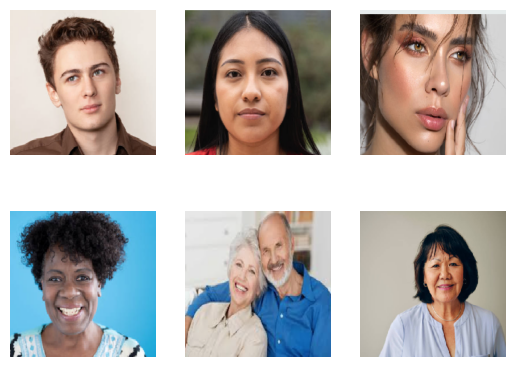

In [ ]:
# load all images in a directory into memory
def load_images(path, size=(256,256)):
	data_list = list()
	# enumerate filenames in directory, assume all are images
	for filename in listdir(path):
		# load and resize the image
		pixels = load_img(path + filename, target_size=size)
		# convert to numpy array
		pixels = img_to_array(pixels)
		# store
		data_list.append(pixels)
	return asarray(data_list)


# dataset path
path = '/content/drive/MyDrive/young2old/'

# load dataset A - Monet paintings
dataA_all = load_images(path + 'trainA/')
print('Loaded dataA: ', dataA_all.shape)

from sklearn.utils import resample
#To get a subset of all images, for faster training during demonstration
dataA = resample(dataA_all, 
                 replace=False,     
                 n_samples=50,    
                 random_state=42) 

# load dataset B - Photos 
dataB_all = load_images(path + 'trainB/')
print('Loaded dataB: ', dataB_all.shape)
#Get a subset of all images, for faster training during demonstration
#We could have just read the list of files and only load a subset, better memory management. 
dataB = resample(dataB_all, 
                 replace=False,     
                 n_samples=50,    
                 random_state=42) 

# plot source images
n_samples = 3
for i in range(n_samples):
	plt.subplot(2, n_samples, 1 + i)
	plt.axis('off')
	plt.imshow(dataA[i].astype('uint8'))
# plot target image
for i in range(n_samples):
	plt.subplot(2, n_samples, 1 + n_samples + i)
	plt.axis('off')
	plt.imshow(dataB[i].astype('uint8'))
plt.show()

In [ ]:
# load dataset A - Monet paintings
dataA_all = load_images(path + 'trainA/')
print('Loaded dataA: ', dataA_all.shape)

from sklearn.utils import resample
#To get a subset of all images, for faster training during demonstration
dataA = resample(dataA_all, 
                 replace=False,     
                 n_samples=50,    
                 random_state=42) 

# load dataset B - Photos 
dataB_all = load_images(path + 'trainB/')
print('Loaded dataB: ', dataB_all.shape)
#Get a subset of all images, for faster training during demonstration
#We could have just read the list of files and only load a subset, better memory management. 
dataB = resample(dataB_all, 
                 replace=False,     
                 n_samples=50,    
                 random_state=42) 


Loaded dataA:  (115, 256, 256, 3)
Loaded dataB:  (115, 256, 256, 3)


In [ ]:

A_data = resample(dataA_all, 
                 replace=False,     
                 n_samples=20,    
                 random_state=42) # reproducible results

B_data = resample(dataB_all, 
                 replace=False,     
                 n_samples=20,    
                 random_state=42) # reproducible results

A_data = (A_data - 127.5) / 127.5
B_data = (B_data - 127.5) / 127.5


1/1 [==============================] - 1s 1s/step


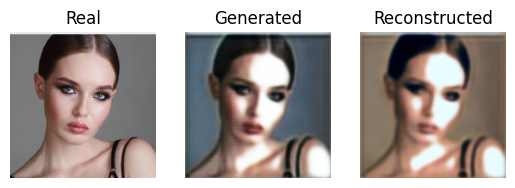

1/1 [==============================] - 0s 31ms/step


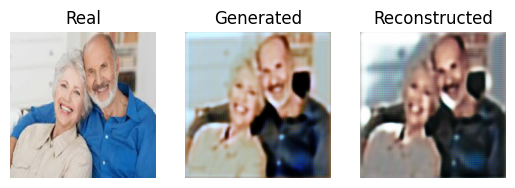

In [ ]:
# plot A->B->A (Monet to photo to Monet)
A_real = select_sample(A_data, 1)
B_generated  = model_AtoB.predict(A_real)
A_reconstructed = model_BtoA.predict(B_generated)
show_plot(A_real, B_generated, A_reconstructed)
# plot B->A->B (Photo to Monet to Photo)
B_real = select_sample(B_data, 1)
A_generated  = model_BtoA.predict(B_real)
B_reconstructed = model_AtoB.predict(A_generated)
show_plot(B_real, A_generated, B_reconstructed)



In [ ]:
test_image = load_img('/content/drive/MyDrive/test2.png',target_size=(256,256))

In [ ]:
##########################
#Load a single custom image

test_image = img_to_array(test_image)
test_image_input = np.array([test_image])  # Convert single image to a batch.
test_image_input = (test_image_input - 127.5) / 127.5

1/1 [==============================] - 0s 29ms/step


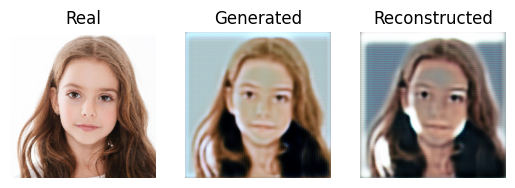

In [ ]:


# plot B->A->B (Photo to Monet to Photo)
monet_generated  = model_BtoA.predict(test_image_input)
photo_reconstructed = model_AtoB.predict(monet_generated)
show_plot(test_image_input, monet_generated, photo_reconstructed)

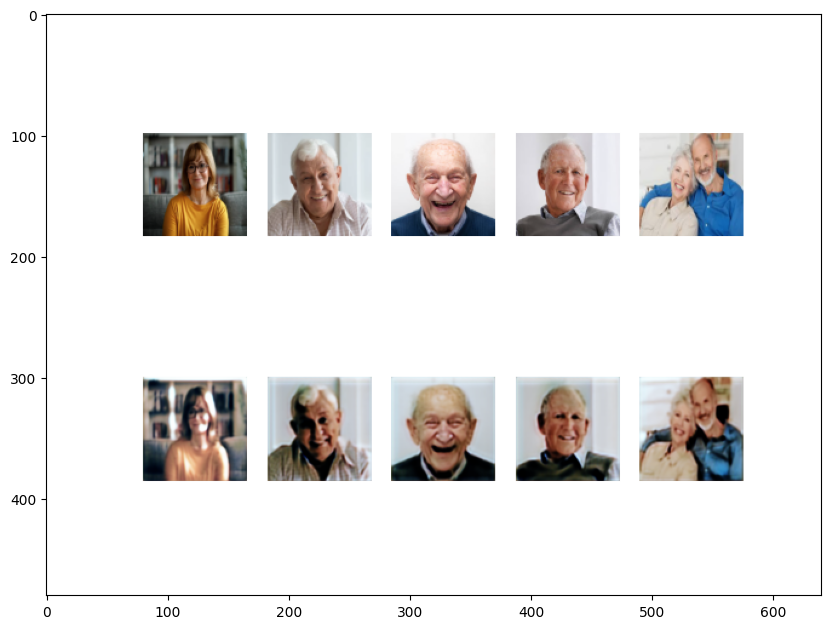

In [ ]:
plt.figure(figsize=(10,10))
img= plt.imread("/content/BtoA_generated_plot_000500.png")
plt.imshow(img)

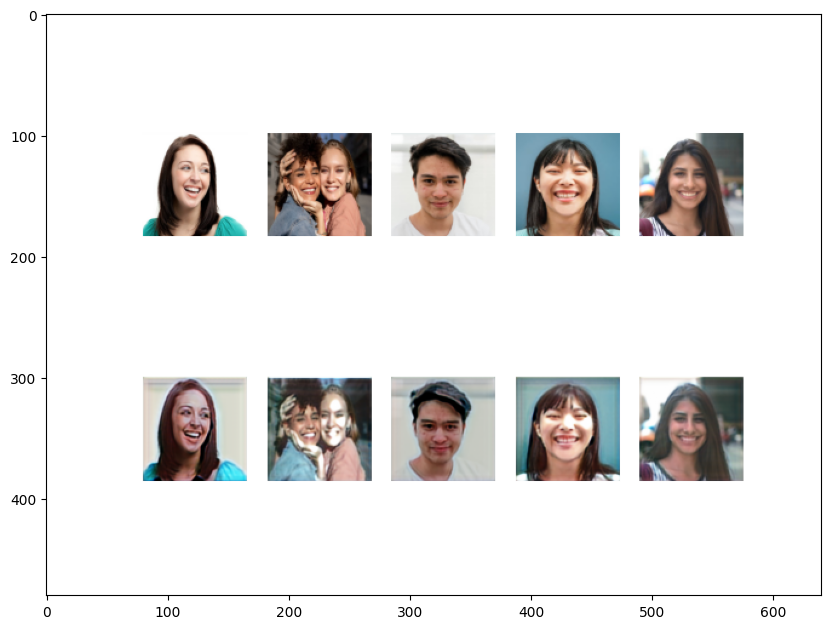

In [ ]:
plt.figure(figsize=(10,10))
img= plt.imread("/content/AtoB_generated_plot_001000.png")
plt.imshow(img)

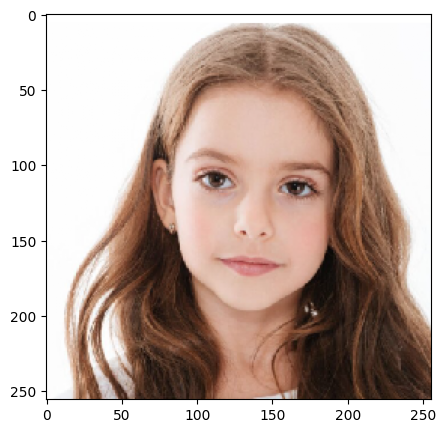

In [ ]:

plt.figure(figsize=(5,5))
plt.imshow( (test_image_input.reshape(256, 256, 3)+ 1) / 2.0)

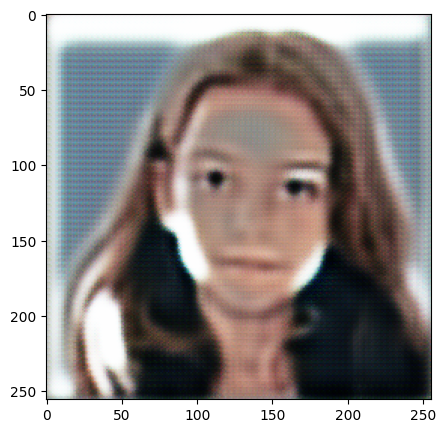

In [ ]:
plt.figure(figsize=(5,5))
plt.imshow( (photo_reconstructed.reshape(256, 256, 3)+ 1) / 2.0)